# Курсовой проект

In [1]:
# Александр Валентинович Дунаев
# Группа 1401

## Задание:

Используя данные из обучающего датасета (train.csv), построить модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели, предсказать цены для квартир из тестового датасета (test.csv).

### Подключение библиотек и скриптов

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

### Загрузка и первичный анализ датасета

Описание датасета:

* Id - идентификационный номер квартиры
* DistrictId - идентификационный номер района
* Rooms - количество комнат
* Square - площадь
* LifeSquare - жилая площадь
* KitchenSquare - площадь кухни
* Floor - этаж
* HouseFloor - количество этажей в доме
* HouseYear - год постройки дома
* Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
* Social_1, Social_2, Social_3 - социальные показатели местности
* Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
* Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
* Price - цена квартиры

Пути к файлам:

In [3]:
TRAIN_DATASET_PATH = './train.csv'
TEST_DATASET_PATH = './test.csv'

Загрузка данных:

In [4]:
df_train = pd.read_csv(TRAIN_DATASET_PATH, index_col='Id')
df_test = pd.read_csv(TEST_DATASET_PATH, index_col='Id')

Первичный анализ обучающего датасета:

In [5]:
df_train.shape

(10000, 19)

In [6]:
df_train.head()

DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
Id                                                                      
14038          35    2.0  47.981561   29.442751            6.0      7   
15053          41    3.0  65.683640   40.049543            8.0      7   
4765           53    2.0  44.947953   29.197612            0.0      8   
5809           58    2.0  53.352981   52.731512            9.0      8   
10783          99    1.0  39.649192   23.776169            7.0     11   

       HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
Id                                                                      
14038         9.0       1969   0.089040         B         B        33   
15053         9.0       1978   0.000070         B         B        46   
4765         12.0       1968   0.049637         B         B        34   
5809         17.0       1977   0.437885         B         B        23   
10783        12.0       1976   0.012339         B         B        35   

       Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  \
Id                                                                      
14038      7976         5           NaN            0       11       B   
15053     10309         1         240.0            1       16       B   
4765       7759         0         229.0            1        3       B   
5809       5735         3        1084.0            0        5       B   
10783      5776         1        2078.0            2        4       B   

               Price  
Id                    
14038  184966.930730  
15053  300009.450063  
4765   220925.908524  
5809   175616.227217  
10783  150226.531644

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14038 to 6306
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     10000 non-null  int64  
 1   Rooms          10000 non-null  float64
 2   Square         10000 non-null  float64
 3   LifeSquare     7887 non-null   float64
 4   KitchenSquare  10000 non-null  float64
 5   Floor          10000 non-null  int64  
 6   HouseFloor     10000 non-null  float64
 7   HouseYear      10000 non-null  int64  
 8   Ecology_1      10000 non-null  float64
 9   Ecology_2      10000 non-null  object 
 10  Ecology_3      10000 non-null  object 
 11  Social_1       10000 non-null  int64  
 12  Social_2       10000 non-null  int64  
 13  Social_3       10000 non-null  int64  
 14  Healthcare_1   5202 non-null   float64
 15  Helthcare_2    10000 non-null  int64  
 16  Shops_1        10000 non-null  int64  
 17  Shops_2        10000 non-null  object 
 18  Pri

Признаки 'LifeSquare' и 'Healthcare_1' содержат пропущенные значения.

In [8]:
df_train.describe()

DistrictId         Rooms        Square   LifeSquare  KitchenSquare  \
count  10000.000000  10000.000000  10000.000000  7887.000000   10000.000000   
mean      50.400800      1.890500     56.315775    37.199645       6.273300   
std       43.587592      0.839512     21.058732    86.241209      28.560917   
min        0.000000      0.000000      1.136859     0.370619       0.000000   
25%       20.000000      1.000000     41.774881    22.769832       1.000000   
50%       36.000000      2.000000     52.513310    32.781260       6.000000   
75%       75.000000      2.000000     65.900625    45.128803       9.000000   
max      209.000000     19.000000    641.065193  7480.592129    2014.000000   

              Floor    HouseFloor     HouseYear     Ecology_1      Social_1  \
count  10000.000000  10000.000000  1.000000e+04  10000.000000  10000.000000   
mean       8.526700     12.609400  3.990166e+03      0.118858     24.687000   
std        5.241148      6.775974  2.005003e+05      0.119025     17.532614   
min        1.000000      0.000000  1.910000e+03      0.000000      0.000000   
25%        4.000000      9.000000  1.974000e+03      0.017647      6.000000   
50%        7.000000     13.000000  1.977000e+03      0.075424     25.000000   
75%       12.000000     17.000000  2.001000e+03      0.195781     36.000000   
max       42.000000    117.000000  2.005201e+07      0.521867     74.000000   

           Social_2      Social_3  Healthcare_1   Helthcare_2       Shops_1  \
count  10000.000000  10000.000000   5202.000000  10000.000000  10000.000000   
mean    5352.157400      8.039200   1142.904460      1.319500      4.231300   
std     4006.799803     23.831875   1021.517264      1.493601      4.806341   
min      168.000000      0.000000      0.000000      0.000000      0.000000   
25%     1564.000000      0.000000    350.000000      0.000000      1.000000   
50%     5285.000000      2.000000    900.000000      1.000000      3.000000   
75%     7227.000000      5.000000   1548.000000      2.000000      6.000000   
max    19083.000000    141.000000   4849.000000      6.000000     23.000000   

               Price  
count   10000.000000  
mean   214138.857399  
std     92872.293865  
min     59174.778028  
25%    153872.633942  
50%    192269.644879  
75%    249135.462171  
max    633233.466570

Исходя из предварительного анализа природной сущности признаков наблюдаются подозрительные максимумы для признаков 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare' и 'HouseYear'. Необходимо выполнить анализ аномальных значений в данных признаках. 

Первичный анализ тестового датасета:

In [9]:
df_test.shape

(5000, 18)

In [10]:
df_test.head()

DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
Id                                                                      
725            58    2.0  49.882643   33.432782            6.0      6   
15856          74    2.0  69.263183         NaN            1.0      6   
5480          190    1.0  13.597819   15.948246           12.0      2   
15664          47    2.0  73.046609   51.940842            9.0     22   
14275          27    1.0  47.527111   43.387569            1.0     17   

       HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
Id                                                                      
725          14.0       1972   0.310199         B         B        11   
15856         1.0       1977   0.075779         B         B         6   
5480          5.0       1909   0.000000         B         B        30   
15664        22.0       2007   0.101872         B         B        23   
14275        17.0       2017   0.072158         B         B         2   

       Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  
Id                                                                     
725        2748         1           NaN            0        0       B  
15856      1437         3           NaN            0        2       B  
5480       7538        87        4702.0            5        5       B  
15664      4583         3           NaN            3        3       B  
14275       629         1           NaN            0        0       A

In [11]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 725 to 12504
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     5000 non-null   int64  
 1   Rooms          5000 non-null   float64
 2   Square         5000 non-null   float64
 3   LifeSquare     3959 non-null   float64
 4   KitchenSquare  5000 non-null   float64
 5   Floor          5000 non-null   int64  
 6   HouseFloor     5000 non-null   float64
 7   HouseYear      5000 non-null   int64  
 8   Ecology_1      5000 non-null   float64
 9   Ecology_2      5000 non-null   object 
 10  Ecology_3      5000 non-null   object 
 11  Social_1       5000 non-null   int64  
 12  Social_2       5000 non-null   int64  
 13  Social_3       5000 non-null   int64  
 14  Healthcare_1   2623 non-null   float64
 15  Helthcare_2    5000 non-null   int64  
 16  Shops_1        5000 non-null   int64  
 17  Shops_2        5000 non-null   object 
dtypes: fl

Признаки 'LifeSquare' и 'Healthcare_1' содержат пропущенные значения.

In [12]:
df_test.describe()

DistrictId        Rooms       Square   LifeSquare  KitchenSquare  \
count  5000.000000  5000.000000  5000.000000  3959.000000    5000.000000   
mean     51.279200     1.910000    56.449500    36.158810       5.976800   
std      44.179466     0.838594    19.092787    17.825287       9.950018   
min       0.000000     0.000000     1.378543     0.333490       0.000000   
25%      21.000000     1.000000    41.906231    23.092026       1.000000   
50%      37.000000     2.000000    52.921340    32.925087       6.000000   
75%      77.000000     2.000000    66.285129    45.174091       9.000000   
max     212.000000    17.000000   223.453689   303.071094     620.000000   

             Floor   HouseFloor    HouseYear    Ecology_1     Social_1  \
count  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000   
mean      8.632000    12.601000  1984.392600     0.119874    24.933800   
std       5.483228     6.789213    18.573149     0.120070    17.532202   
min       1.000000     0.000000  1908.000000     0.000000     0.000000   
25%       4.000000     9.000000  1973.000000     0.019509     6.000000   
50%       7.000000    12.000000  1977.000000     0.072158    25.000000   
75%      12.000000    17.000000  2000.000000     0.195781    36.000000   
max      78.000000    99.000000  2020.000000     0.521867    74.000000   

           Social_2     Social_3  Healthcare_1  Helthcare_2      Shops_1  
count   5000.000000  5000.000000   2623.000000   5000.00000  5000.000000  
mean    5406.900000     8.262600   1146.657263      1.31940     4.242800  
std     4026.614773    23.863762   1044.744231      1.47994     4.777365  
min      168.000000     0.000000      0.000000      0.00000     0.000000  
25%     1564.000000     0.000000    325.000000      0.00000     1.000000  
50%     5285.000000     2.000000    900.000000      1.00000     3.000000  
75%     7287.000000     5.000000   1548.000000      2.00000     6.000000  
max    19083.000000   141.000000   4849.000000      6.00000    23.000000

Исходя из предварительного анализа природной сущности признаков наблюдаются подозрительные максимумы для признаков 'Rooms', 'Square', 'LifeSquare' и 'KitchenSquare'. Необходимо выполнить анализ анаомальных значений в данных признаках.

### Приведение типов

Приведение типов признаков делается на основе анализа их природной сущности.

In [13]:
df_train.dtypes

DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [14]:
df_train['DistrictId'] = df_train['DistrictId'].astype(str)
df_test['DistrictId'] = df_test['DistrictId'].astype(str)

### Обзор данных

Целевая переменная:

In [15]:
target_mean = round(df_train['Price'].mean(), 2)
target_median = df_train['Price'].median()
print(f"Целевая переменная 'Price':\
      \n- среднее: {target_mean};\
      \n- медиана: {target_median}.")

Целевая переменная 'Price':      
- среднее: 214138.86;      
- медиана: 192269.64487934904.


/Users/alexander/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


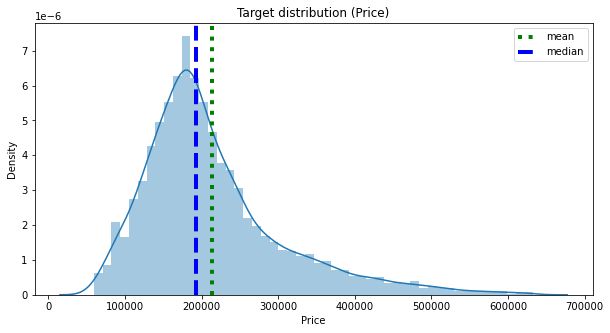

In [16]:
plt.figure(figsize = (10, 5))
sns.distplot(df_train['Price'])
plt.title('Target distribution (Price)');
plt.axvline(target_mean, color='g', linestyle=':', linewidth=4, label='mean')
plt.axvline(target_median, color='b', linestyle='--', linewidth=4, label='median')
plt.legend()

Распределение целевой переменной имеет позитивное искажение. В случае применения модели линейной регрессии логарифмизация целевой переменной может увеличить точность предсказания.

Количественные признаки:

In [17]:
feature_num_names = df_train.drop('Price', axis=1).select_dtypes(include=['float64', 'int64']).\
        columns.tolist()
feature_num_names

['Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1']

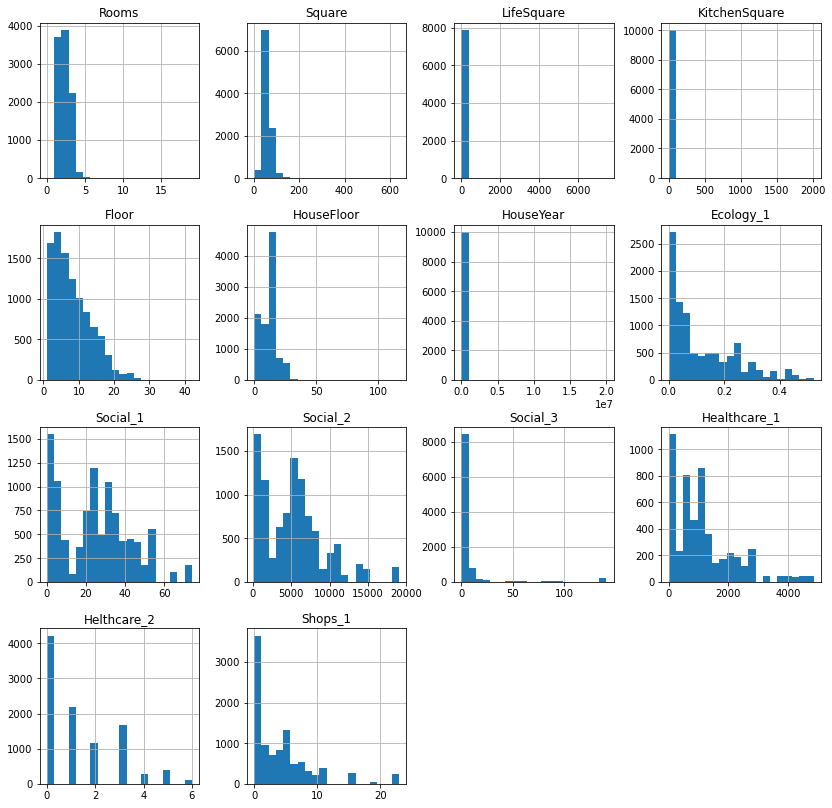

In [18]:
df_train[feature_num_names].hist(figsize=(14,14), bins=20, grid=True);

Признак 'Healthcare_2' выглядит как категориальный признак. Необходимо рассмотреть целесообразность его перевода в категориальный признак.

Признаки имеют преимущественно положительные искажения распределений. В случае применения модели линейной регрессии логарифмизация переменных может увеличить точность предсказания. Необходимо рассмотреть целесообразность логарифмизации признаков с положительными искажениями распределений.

Категориальные признаки:

In [19]:
feature_cat_names = df_train.select_dtypes(include='object').columns.tolist()
feature_cat_names

['DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [20]:
df_train['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
207      1
209      1
196      1
199      1
117      1
Name: DistrictId, Length: 205, dtype: int64

In [21]:
df_train['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

/Users/alexander/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


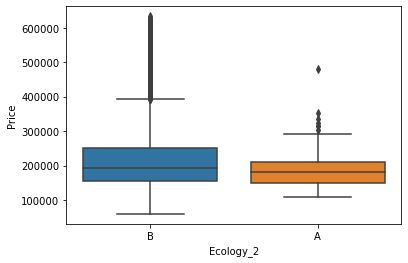

In [22]:
sns.boxplot('Ecology_2', 'Price', data=df_train);

Признак 'Ecology_2' имеет в каждой категории близкие по значению медианы, соотвественно влияние категорий на целевое значение может быть незначительным и исключение данного признака может улучшить точность предсказания модели. Необходимо рассмотреть целесообразность исключения данного признака при построении предсказательной модели.

In [23]:
df_train['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

/Users/alexander/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


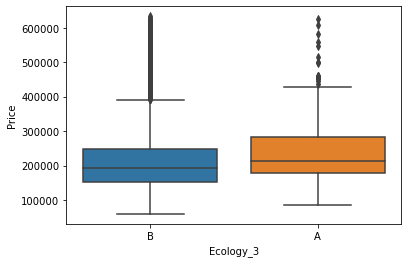

In [24]:
sns.boxplot('Ecology_3', 'Price', data=df_train);

Признак 'Ecology_3' имеет в каждой категории близкие по значению медианы, соотвественно влияние категорий на целевое значение может быть незначительным и исключение данного признака может улучшить точность предсказания модели. Необходимо рассмотреть целесообразность исключения данного признака при построении предсказательной модели.

In [25]:
df_train['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

/Users/alexander/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


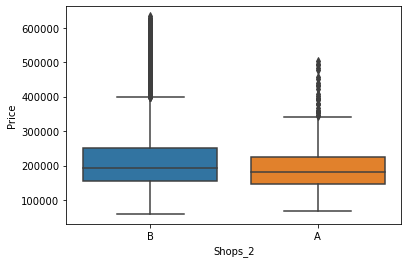

In [26]:
sns.boxplot('Shops_2', 'Price', data=df_train);

Признак 'Shops_2' имеет в каждой категории близкие по значению медианы, соотвественно влияние категорий на целевое значение может быть незначительным и исключение данного признака может улучшить точность предсказания модели. Необходимо рассмотреть целесообразность исключения данного признака при построении предсказательной модели.

Анализ признака 'Helthcare_2' из предположения его категориальности:

/Users/alexander/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


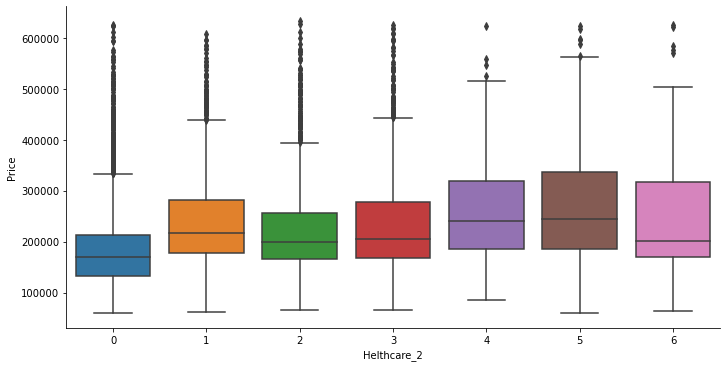

In [27]:
sns.catplot('Helthcare_2', 'Price', kind="box", data=df_train, aspect=2/1);

Признак 'Healthcare_2' имеет в каждой категории близкие по значению медианы, соотвественно влияние категорий на целевое значение может быть незначительным и исключение данного признака может улучшить точность предсказания модели. Необходимо рассмотреть целесообразность исключения данного признака при построении предсказательной модели.

### Обработка категориальных признаков

Рассматриваемые признаки: 'Ecology_2', 'Ecology_3', 'Shops_2'. 

Все рассматриваемые признаки являются бинарными.

Вариант 1. Кодирование категориальных признаков методом Label Encoding:

In [28]:
feature_bin_names = ['Ecology_2', 'Ecology_3', 'Shops_2']
df_train[feature_bin_names] = df_train[feature_bin_names].replace({'A':0, 'B':1})
df_test[feature_bin_names] = df_test[feature_bin_names].replace({'A':0, 'B':1})
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14038 to 6306
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     10000 non-null  object 
 1   Rooms          10000 non-null  float64
 2   Square         10000 non-null  float64
 3   LifeSquare     7887 non-null   float64
 4   KitchenSquare  10000 non-null  float64
 5   Floor          10000 non-null  int64  
 6   HouseFloor     10000 non-null  float64
 7   HouseYear      10000 non-null  int64  
 8   Ecology_1      10000 non-null  float64
 9   Ecology_2      10000 non-null  int64  
 10  Ecology_3      10000 non-null  int64  
 11  Social_1       10000 non-null  int64  
 12  Social_2       10000 non-null  int64  
 13  Social_3       10000 non-null  int64  
 14  Healthcare_1   5202 non-null   float64
 15  Helthcare_2    10000 non-null  int64  
 16  Shops_1        10000 non-null  int64  
 17  Shops_2        10000 non-null  int64  
 18  Pri

### Обработка пропусков

Решение о выборе метода обработки пропусков делается на основе анализа природной сущности признаков.

Абсолютное количество пропусков:

In [29]:
df_train.isna().sum()

DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

Процентное количество пропусков:

In [30]:
round(df_train.isna().mean() * 100, 2)

DistrictId        0.00
Rooms             0.00
Square            0.00
LifeSquare       21.13
KitchenSquare     0.00
Floor             0.00
HouseFloor        0.00
HouseYear         0.00
Ecology_1         0.00
Ecology_2         0.00
Ecology_3         0.00
Social_1          0.00
Social_2          0.00
Social_3          0.00
Healthcare_1     47.98
Helthcare_2       0.00
Shops_1           0.00
Shops_2           0.00
Price             0.00
dtype: float64

Рассматриваемые признаки: 'LifeSquare', 'Healthcare_1'.

#### Обработка пропусков признака LifeSquare

Вариант 2a. Удаление признака 'LifeSquare':

In [31]:
# df_train.drop(['LifeSquare'], axis=1, inplace=True)
# df_test.drop(['LifeSquare'], axis=1, inplace=True)

Вариант 2b. Замена пропущенных значений признака 'LifeSquare' медианой:

In [32]:
# df_train['LifeSquare'].fillna(df_train['LifeSquare'].median(), inplace=True)
# df_test['LifeSquare'].fillna(df_train['LifeSquare'].median(), inplace=True)

Вариант 2с. Замена пропущенных значений признака 'LifeSquare' разницей между значениями признака 'Square' и 'KitchenSquare':

In [33]:
df_train.loc[df_train['LifeSquare'].isna(), 'LifeSquare'] = \
    df_train['Square'] - df_train['KitchenSquare']
df_test.loc[df_test['LifeSquare'].isna(), 'LifeSquare'] = \
    df_test['Square'] - df_test['KitchenSquare']

Вариант 2d. Замена пропущенных значений признака 'LifeSquare' значениями, вычисляемыми с помощью линейной модели:

In [34]:
df_train.corr()['LifeSquare'].sort_values()

Social_1        -0.085086
Healthcare_1    -0.075991
Social_2        -0.072220
Helthcare_2     -0.048584
Ecology_1       -0.031195
Shops_1         -0.019966
Shops_2         -0.018926
KitchenSquare   -0.011965
HouseYear       -0.002767
Ecology_2        0.011353
Social_3         0.013785
Ecology_3        0.018368
HouseFloor       0.020238
Floor            0.036569
Price            0.078917
Rooms            0.148351
Square           0.244776
LifeSquare       1.000000
Name: LifeSquare, dtype: float64

Существенная линейная зависимость с другими признаками не установлена - вариант 2d исключается.

#### Обработка пропусков признака Healthcare_1

In [35]:
df_train['Healthcare_1'].describe()

count    5202.000000
mean     1142.904460
std      1021.517264
min         0.000000
25%       350.000000
50%       900.000000
75%      1548.000000
max      4849.000000
Name: Healthcare_1, dtype: float64

Вариант 3a. Удаление признака 'Healthcare_1':

In [36]:
# df_train.drop(['Healthcare_1'], axis=1, inplace=True)
# df_test.drop(['Healthcare_1'], axis=1, inplace=True)

Вариант 3b. Замена пропущенных значений признака 'Healthcare_1' медианой:

In [37]:
# df_train['Healthcare_1'].fillna(df_train['Healthcare_1'].median(), inplace=True)
# df_test['Healthcare_1'].fillna(df_train['Healthcare_1'].median(), inplace=True)

Вариант 3с. Замена пропущенных значений признака 'Healthcare_1' медианой значений, сгруппированных по признаку 'DistrictId' с дозаполнением оставшихся значений по варианту 3b:

In [38]:
df = pd.concat([
          df_train.groupby('DistrictId')['Healthcare_1'].apply(lambda x: np.nanmean(x)),
          df_train.groupby('DistrictId')['Healthcare_1'].apply(lambda x: np.nanmedian(x)),
          df_train.groupby('DistrictId')['Healthcare_1'].apply(lambda x: np.nanstd(x)),
          df_train.groupby('DistrictId')['Healthcare_1'].count(),
          df_train.groupby('DistrictId')['Healthcare_1'].apply(lambda x: x.isna().sum())
          ], 
          axis=1, keys=['mean', 'median', 'std', 'count', 'nans']).sort_values(by='nans', ascending=False)

<ipython-input-38-bd9be84b0b6e>:2: RuntimeWarning: Mean of empty slice
  df_train.groupby('DistrictId')['Healthcare_1'].apply(lambda x: np.nanmean(x)),
/Users/alexander/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/Users/alexander/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [39]:
df.head()

mean  median        std  count  nans
DistrictId                                            
27                 NaN     NaN        NaN      0   851
1            228.77193   240.0  17.973682     57   595
23             0.00000     0.0   0.000000      1   564
62          2300.00000  2300.0   0.000000      9   238
45                 NaN     NaN        NaN      0   116

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 205 entries, 27 to 99
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   mean    170 non-null    float64
 1   median  170 non-null    float64
 2   std     170 non-null    float64
 3   count   205 non-null    int64  
 4   nans    205 non-null    int64  
dtypes: float64(3), int64(2)
memory usage: 9.6+ KB


In [41]:
df.describe()

mean       median          std       count        nans
count   170.000000   170.000000   170.000000  205.000000  205.000000
mean   1584.727774  1582.361765   283.007361   25.375610   23.404878
std    1113.515462  1201.584725   435.223490   49.090157   85.458607
min       0.000000     0.000000     0.000000    0.000000    0.000000
25%     711.250000   632.250000     0.000000    2.000000    0.000000
50%    1416.556701  1331.000000     0.000000    9.000000    0.000000
75%    2226.063158  2301.000000   438.859513   30.000000   13.000000
max    4849.000000  4849.000000  1951.614716  511.000000  851.000000

In [42]:
df_train.loc[df_train['Healthcare_1'].isna(), 'Healthcare_1'] =\
     df_train.groupby(['DistrictId'])['Healthcare_1'].transform(lambda x: x.median())

df_test.loc[df_test['Healthcare_1'].isna(), 'Healthcare_1'] =\
     df_train.groupby(['DistrictId'])['Healthcare_1'].transform(lambda x: x.median())

In [43]:
df_train['Healthcare_1'].fillna(df_train['Healthcare_1'].median(), inplace=True)
df_test['Healthcare_1'].fillna(df_train['Healthcare_1'].median(), inplace=True)

Вариант 3d. Замена пропущенных значений признака 'Healthcare_1' значениями, вычисляемыми с помощью линейной модели:

In [44]:
df_train.corr()['Healthcare_1'].sort_values()

Shops_2         -0.140371
HouseFloor      -0.126716
Ecology_3       -0.119364
Floor           -0.088716
Ecology_2       -0.042251
LifeSquare      -0.030036
Square          -0.017036
HouseYear       -0.007843
Ecology_1        0.015173
KitchenSquare    0.030635
Rooms            0.047007
Shops_1          0.135887
Social_2         0.142954
Social_3         0.155748
Social_1         0.183114
Price            0.200040
Helthcare_2      0.268244
Healthcare_1     1.000000
Name: Healthcare_1, dtype: float64

Существенная линейная зависимость с другими признаками не установлена - вариант 3d исключается.

In [45]:
df_train.isna().sum()

DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Shops_2          0
Price            0
dtype: int64

In [46]:
df_test.isna().sum()

DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Shops_2          0
dtype: int64

### Обработка аномальных значений

Рассматриваемые признаки: 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear'.

Решение о выборе метода обработки выбросов делается на основе анализа природной сущности признаков.

#### Rooms

Анализ признака:

In [47]:
df_train['Rooms'].describe()

count    10000.000000
mean         1.890500
std          0.839512
min          0.000000
25%          1.000000
50%          2.000000
75%          2.000000
max         19.000000
Name: Rooms, dtype: float64

In [48]:
df_train['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
6.0        1
19.0       1
Name: Rooms, dtype: int64

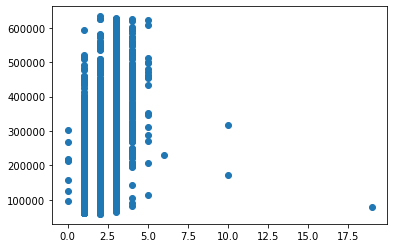

In [49]:
plt.scatter(df_train['Rooms'], df_train['Price']);

/Users/alexander/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


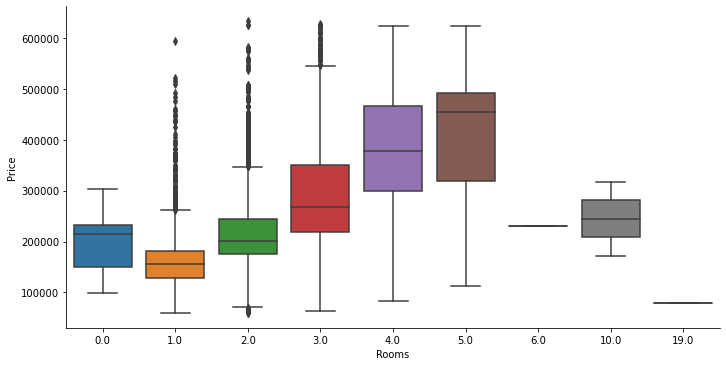

In [50]:
sns.catplot('Rooms', 'Price', kind="box", data=df_train, aspect=2/1);

Наблюдается закономерность роста средней цены за квартиру при увеличении комнат от 1 до 5, что соотвествует здравому смыслу. Примем эту закономерность в качестве критерия адекватности данного признака.

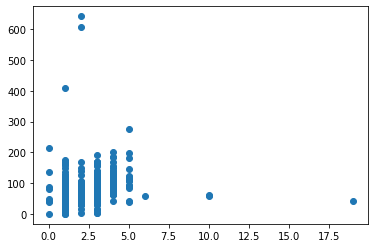

In [51]:
plt.scatter(df_train['Rooms'], df_train['Square']);

/Users/alexander/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


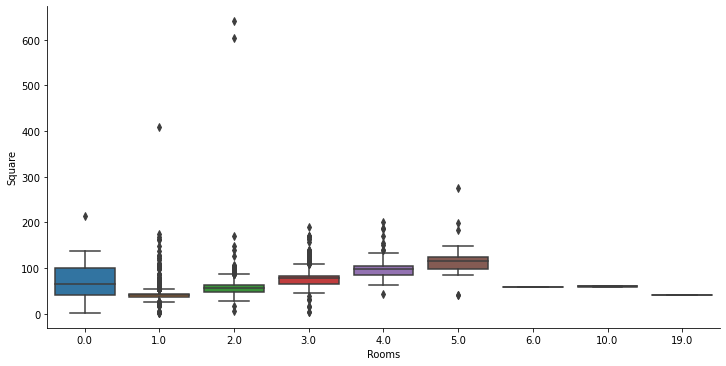

In [52]:
sns.catplot('Rooms', 'Square', kind="box", data=df_train, aspect=2/1);

In [53]:
df_train['Rooms'].mode()

0    2.0
dtype: float64

Вариант 4. Замена аномальных значений признака 'Rooms' модой исходя из критерия адекватности признака:

In [54]:
# df_train.loc[(df_train['Rooms'] > 5)|(df_train['Rooms'] == 0), 'Rooms'] = df_train['Rooms'].mode()[0]
# df_test.loc[(df_test['Rooms'] > 5)|(df_test['Rooms'] == 0), 'Rooms'] = df_train['Rooms'].mode()[0]

/Users/alexander/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


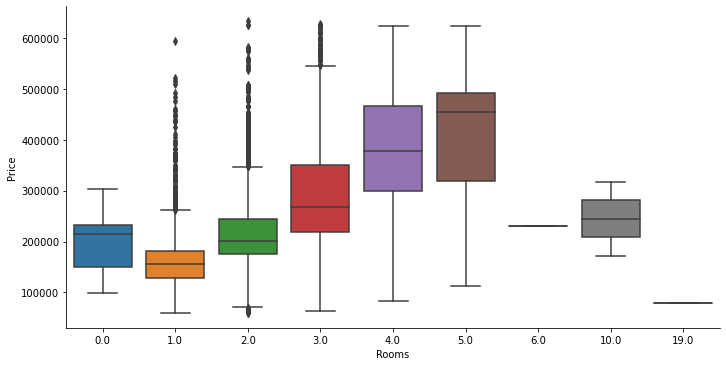

In [55]:
sns.catplot('Rooms', 'Price', kind="box", data=df_train, aspect=2/1);

#### Square, LifeSquare, KitchenSquare

Анализ признаков:

In [56]:
fig = go.Figure(data=[go.Scatter3d(
    x=df_train['Square'],
    y=df_train['LifeSquare'],
    z=df_train['KitchenSquare'], 
    mode='markers',
    marker=dict(
        size=5,
        color=df_train['Price'], 
        colorscale='jet',  
        colorbar=dict(thickness=10),
        line=dict(width=2, color='DarkSlateGrey')
    )
)])

fig.update_layout(
    margin=dict(l=0, r=0, b=0, t=0),
    scene=dict(
        xaxis_title='Square',
        yaxis_title='LifeSquare',
        zaxis_title='KitchenSquare'),
    )

fig.show()

In [57]:
df_train[['Square', 'LifeSquare', 'KitchenSquare']].describe()

Square    LifeSquare  KitchenSquare
count  10000.000000  10000.000000   10000.000000
mean      56.315775     41.799474       6.273300
std       21.058732     77.823543      28.560917
min        1.136859      0.370619       0.000000
25%       41.774881     25.494155       1.000000
50%       52.513310     37.040829       6.000000
75%       65.900625     49.823229       9.000000
max      641.065193   7480.592129    2014.000000

In [58]:
len(df_train.loc[df_train['Square'] > (df_train['LifeSquare'] + df_train['KitchenSquare'])])

7042

Наблюдается закономерность 'Square' > ('LifeSquare' + 'KitchenSquare'), что соотвествует здравому смыслу. Примем эту закономерность в качестве критерия адекватности данных признаков.

Анализ признака 'KitchenSquare':

In [59]:
df_train['KitchenSquare'].value_counts().head()

1.0     2460
8.0     1306
5.0     1169
10.0    1075
6.0     1038
Name: KitchenSquare, dtype: int64

/Users/alexander/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



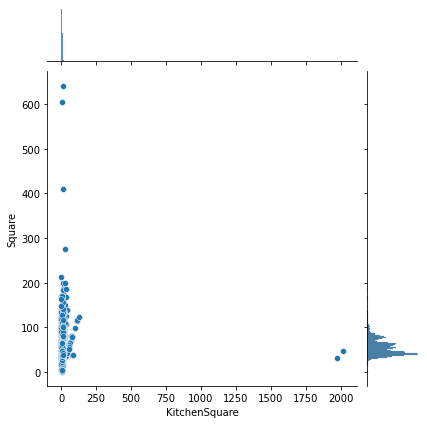

In [60]:
sns.jointplot(df_train['KitchenSquare'], df_train['Square'], kind='scatter', height=6);

Предположение о критерии выброса признака 'KitchenSquare':

In [61]:
len(df_train.loc[df_train['KitchenSquare'] > 123, :])

2

In [62]:
df_train['KitchenSquare'].median()

6.0

Вариант 5a. Замена аномальных значений признака 'KitchenSquare' медианой исходя из предположения о критерии выброса:

In [63]:
# df_train.loc[df_train['KitchenSquare'] > 123, 'KitchenSquare'] = df_train['KitchenSquare'].median()
# df_test.loc[df_test['KitchenSquare'] > 123, 'KitchenSquare'] = df_train['KitchenSquare'].median()

In [64]:
# sns.jointplot(df_train['KitchenSquare'], df_train['Square'], kind='scatter', height=6);

Анализ признака 'LifeSquare':

In [65]:
df_train['LifeSquare'].value_counts().head()

48.650696    1
45.550797    1
33.166491    1
34.021496    1
21.580888    1
Name: LifeSquare, dtype: int64

/Users/alexander/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



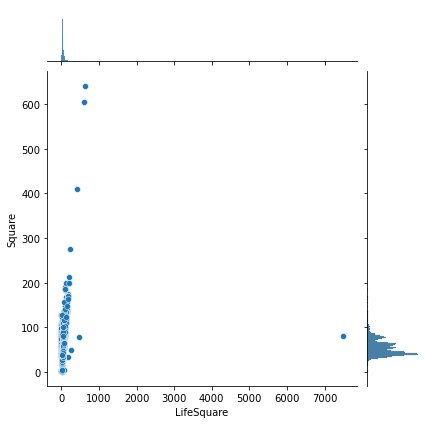

In [66]:
sns.jointplot(df_train['LifeSquare'], df_train['Square'], kind='scatter', height=6);

Предположение о критерии выброса признака 'LifeSquare':

In [67]:
len(df_train.loc[df_train['LifeSquare'] > 400])

5

Вариант 5b. Замена аномальных значений признака 'LifeSquare' медианой исходя из предположения о критерии выброса:

In [68]:
df_train.loc[(df_train['LifeSquare'] > 400), 'LifeSquare'] = \
        df_train['LifeSquare'].median()

df_test.loc[(df_test['LifeSquare'] > 400), 'LifeSquare'] = \
        df_train['LifeSquare'].median()

/Users/alexander/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



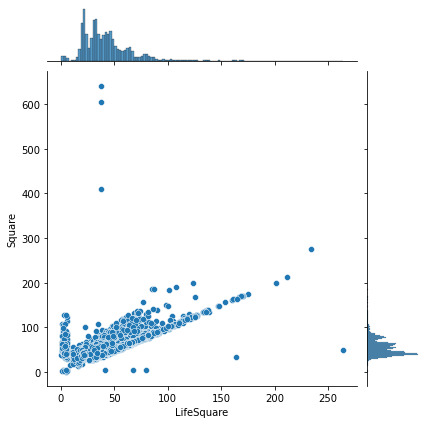

In [69]:
sns.jointplot(df_train['LifeSquare'], df_train['Square'], kind='scatter', height=6);

Анализ признака 'Square':

In [70]:
df_train['Square'].value_counts().head()

51.576501    1
29.648057    1
28.643684    1
60.160707    1
51.971604    1
Name: Square, dtype: int64

/Users/alexander/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



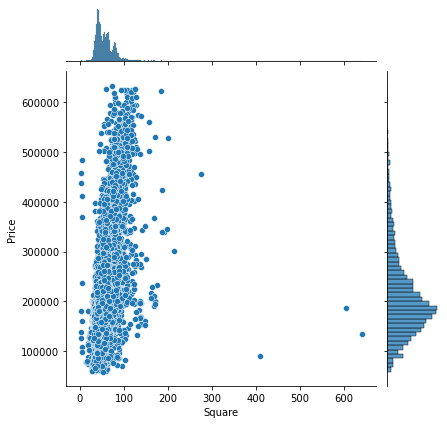

In [71]:
sns.jointplot(df_train['Square'], df_train['Price'], kind='scatter', height=6);

Предположение о критерии выброса признака 'Square':

In [72]:
len(df_train.loc[(df_train['Square'] > 400) | (df_train['Square'] < 10), :])

15

In [73]:
df_train['Square'].median()

52.51330992401352

Вариант 5c. Замена аномальных значений признака 'Square' медианой исходя из предположения о критерии выброса:

In [74]:
df_train.loc[(df_train['Square'] > 400) | (df_train['Square'] < 10), 'Square'] = \
            df_train['Square'].median()

df_test.loc[(df_test['Square'] > 400) | (df_test['Square'] < 10), 'Square'] = \
            df_train['Square'].median()

/Users/alexander/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



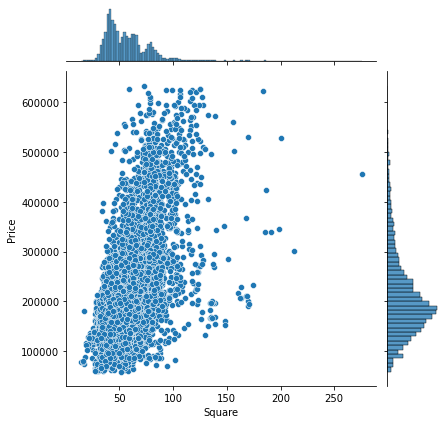

In [75]:
sns.jointplot(df_train['Square'], df_train['Price'], kind='scatter', height=6);

Вариант 5d. Замена аномальных значений признаков 'Square', 'LifeSquare' и 'KitchenSquare' их медианами исходя из критерия адекватности данных признаков:

In [76]:
# square_outliers_train = df_train.loc[(df_train['Square'] < (df_train['LifeSquare'] + \
#                                                              df_train['KitchenSquare']))].index
# square_outliers_test = df_test.loc[(df_test['Square'] < (df_test['LifeSquare'] + \
#                                                              df_test['KitchenSquare']))].index

# df_train.loc[square_outliers_train, ['Square', 'LifeSquare', 'KitchenSquare']] = \
# df_train['Square'].median(), df_train['LifeSquare'].median(), df_train['KitchenSquare'].median()

# df_test.loc[square_outliers_test, ['Square', 'LifeSquare', 'KitchenSquare']] = \
# df_train['Square'].median(), df_train['LifeSquare'].median(), df_train['KitchenSquare'].median()

In [77]:
df_train[['Square', 'LifeSquare', 'KitchenSquare']].describe()

Square    LifeSquare  KitchenSquare
count  10000.000000  10000.000000   10000.000000
mean      56.224584     40.858538       6.273300
std       19.063483     20.570557      28.560917
min       13.784865      0.370619       0.000000
25%       41.794392     25.494155       1.000000
50%       52.513310     37.039625       6.000000
75%       65.889736     49.771534       9.000000
max      275.645284    263.542020    2014.000000

In [78]:
fig = go.Figure(data=[go.Scatter3d(
    x=df_train['Square'],
    y=df_train['LifeSquare'],
    z=df_train['KitchenSquare'], 
    mode='markers',
    marker=dict(
        size=5,
        color=df_train['Price'], 
        colorscale='jet',  
        colorbar=dict(thickness=10),
        line=dict(width=2, color='DarkSlateGrey')
    )
)])

fig.update_layout(
    margin=dict(l=0, r=0, b=0, t=0),
    scene=dict(
        xaxis_title='Square',
        yaxis_title='LifeSquare',
        zaxis_title='KitchenSquare'),
    )

fig.show()

#### HouseFloor, Floor

In [79]:
df_train[['HouseFloor', 'Floor']].describe()

HouseFloor         Floor
count  10000.000000  10000.000000
mean      12.609400      8.526700
std        6.775974      5.241148
min        0.000000      1.000000
25%        9.000000      4.000000
50%       13.000000      7.000000
75%       17.000000     12.000000
max      117.000000     42.000000

In [80]:
len(df_train.loc[df_train['HouseFloor'] > df_train['Floor']])

7270

Наблюдается закономерность 'HouseFloor' > 'Floor', что соотвествует здравому смыслу. Примем эту закономерность в качестве критерия адекватности данных признаков.

In [81]:
df_train['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [82]:
df_train['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42])

/Users/alexander/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



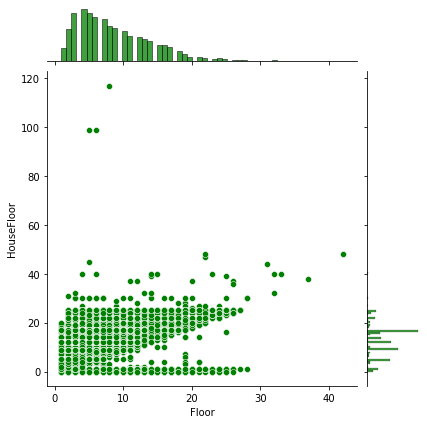

In [83]:
sns.jointplot(df_train['Floor'], df_train['HouseFloor'], kind='scatter', height=6, color='g');

In [84]:
df_train['HouseFloor'].median()

13.0

In [85]:
df_train['Floor'].median()

7.0

Предположение о критерии выброса признака 'HouseFloor':

In [86]:
len(df_train[(df_train['HouseFloor'] == 0) | (df_train['HouseFloor'] > 98)])

272

Вариант 6a. Замена аномальных значений признака 'HouseFloor' медианой исходя из предположения о критерии выброса:

In [87]:
df_train.loc[df_train['HouseFloor'] == 0, 'HouseFloor'] = df_train['HouseFloor'].median()
df_test.loc[df_test['HouseFloor'] == 0, 'HouseFloor'] = df_train['HouseFloor'].median()

df_train.loc[df_train['HouseFloor'] > 98, 'HouseFloor'] = df_train['HouseFloor'].median()
df_test.loc[df_test['HouseFloor'] > 98, 'HouseFloor'] = df_train['HouseFloor'].median()

/Users/alexander/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



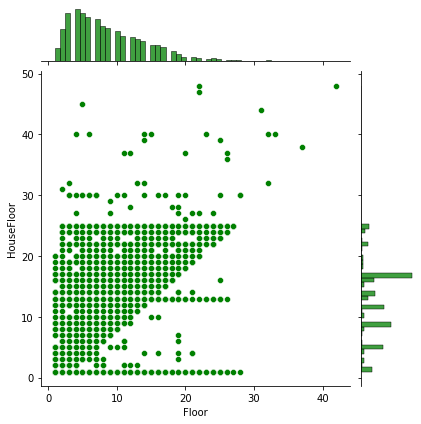

In [88]:
sns.jointplot(df_train['Floor'], df_train['HouseFloor'], kind='scatter', height=6, color='g');

Проверка критерия адекватности:

In [89]:
floor_outliers_train = df_train.loc[df_train['Floor'] > df_train['HouseFloor']].index
floor_outliers_test = df_test.loc[df_test['Floor'] > df_test['HouseFloor']].index

In [90]:
floor_outliers_train

Int64Index([11993, 10953,  2119, 11935,  4378,  6486,  9371, 10521, 10103,
             8443,
            ...
            10361,  4660, 16050, 12590,  5071,  2237, 16159,  4145, 11553,
               77],
           dtype='int64', name='Id', length=1610)

In [91]:
floor_outliers_test

Int64Index([15856, 15975,  5214, 11160,  2449,  9348, 12749, 12309,  5452,
             2831,
            ...
             7639, 16722,  9157,  5820, 16087, 15181, 16064,  2591, 14562,
             5783],
           dtype='int64', name='Id', length=783)

Вариант 6b. Замена аномальных значений признаков 'Floor' и 'HouseFloor' их медианами исходя из критерия адекватности данных признаков:

In [92]:
# df_train.loc[floor_outliers_train, 'Floor'] = df_train['Floor'].median()
# df_train.loc[floor_outliers_train, 'HouseFloor'] = df_train['HouseFloor'].median()
# df_test.loc[floor_outliers_test, 'Floor'] = df_train['Floor'].median()
# df_test.loc[floor_outliers_test, 'HouseFloor'] = df_train['HouseFloor'].median()

In [93]:
# floor_outliers_train = df_train.loc[df_train['Floor'] > df_train['HouseFloor']].index
# floor_outliers_test = df_test.loc[df_test['Floor'] > df_test['HouseFloor']].index

In [94]:
# floor_outliers_train

In [95]:
# floor_outliers_test

In [96]:
df_train[['HouseFloor', 'Floor']].describe()

HouseFloor         Floor
count  10000.000000  10000.000000
mean      12.931500      8.526700
std        6.241322      5.241148
min        1.000000      1.000000
25%        9.000000      4.000000
50%       13.000000      7.000000
75%       17.000000     12.000000
max       48.000000     42.000000

#### HouseYear

In [97]:
df_train['HouseYear'].median()

1977.0

In [98]:
df_train['HouseYear'].sort_values(ascending=False)

Id
10814    20052011
11607        4968
8892         2020
3445         2020
6731         2020
           ...   
7920         1916
6751         1914
14556        1912
2085         1912
13288        1910
Name: HouseYear, Length: 10000, dtype: int64

Выявлены значения признака 'HouseYear' > 2021, что не соотвествует здравому смыслу. Примем это несоотвествие в качестве критерия адекватности данного признака.

In [99]:
df_train[df_train['HouseYear'] < 2021]['HouseYear']

Id
14038    1969
15053    1978
4765     1968
5809     1977
10783    1976
         ... 
77       1968
6159     2000
5123     2015
5400     1961
6306     1990
Name: HouseYear, Length: 9998, dtype: int64

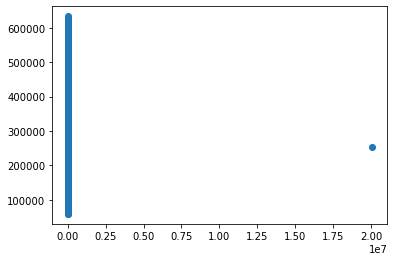

In [100]:
plt.scatter(df_train['HouseYear'], df_train['Price']);

Вариант 7. Замена аномальных значений признака 'HouseYear' медианой исходя из критерия адекватности признака:

In [101]:
df_train.loc[df_train['HouseYear'] > 2021, 'HouseYear'] = df_train['HouseYear'].median()

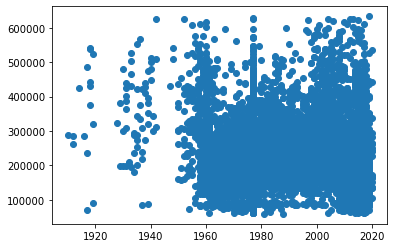

In [102]:
plt.scatter(df_train['HouseYear'], df_train['Price']);

### Обработка редких категорий

Обработка редких категорий осуществляется, в основном, путём их объединения в новый признак или добавления к существующим.

В данной задаче обработка редких категорий не предусмотрена.

### Создание новых признаков

Вариант 8a. Добавление нового временного признака "стоимость квадратного метра":

In [103]:
df_train['PricePerSquare'] = df_train['Price'] / df_train['Square']
df_train.head()

DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
Id                                                                     
14038         35    2.0  47.981561   29.442751            6.0      7   
15053         41    3.0  65.683640   40.049543            8.0      7   
4765          53    2.0  44.947953   29.197612            0.0      8   
5809          58    2.0  53.352981   52.731512            9.0      8   
10783         99    1.0  39.649192   23.776169            7.0     11   

       HouseFloor  HouseYear  Ecology_1  Ecology_2  Ecology_3  Social_1  \
Id                                                                        
14038         9.0       1969   0.089040          1          1        33   
15053         9.0       1978   0.000070          1          1        46   
4765         12.0       1968   0.049637          1          1        34   
5809         17.0       1977   0.437885          1          1        23   
10783        12.0       1976   0.012339          1          1        35   

       Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1  Shops_2  \
Id                                                                       
14038      7976         5         750.0            0       11        1   
15053     10309         1         240.0            1       16        1   
4765       7759         0         229.0            1        3        1   
5809       5735         3        1084.0            0        5        1   
10783      5776         1        2078.0            2        4        1   

               Price  PricePerSquare  
Id                                    
14038  184966.930730     3854.958571  
15053  300009.450063     4567.491245  
4765   220925.908524     4915.149522  
5809   175616.227217     3291.591637  
10783  150226.531644     3788.892642

Вариант 8b. Добавление нового признака "сгруппированная по районам медианная стоимость квадратного метра" с дозаполнением пропущенных значений медианой:

In [104]:
price_per_square_by_district_id = df_train.groupby(['DistrictId'], as_index=False)\
                        .agg({'PricePerSquare':'median'})\
                        .rename(columns={'PricePerSquare':'PricePerSquareByDistrictId'})

In [105]:
price_per_square_by_district_id.head()

DistrictId  PricePerSquareByDistrictId
0          0                 3935.906409
1          1                 3251.647396
2         10                 4458.893222
3        100                 4933.389994
4        101                 4188.414745

In [106]:
df_train = df_train.merge(price_per_square_by_district_id, on=['DistrictId'], how='left').set_index(df_train.index)
df_test = df_test.merge(price_per_square_by_district_id, on=['DistrictId'], how='left').set_index(df_test.index)

In [107]:
df_train.head()

DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
Id                                                                     
14038         35    2.0  47.981561   29.442751            6.0      7   
15053         41    3.0  65.683640   40.049543            8.0      7   
4765          53    2.0  44.947953   29.197612            0.0      8   
5809          58    2.0  53.352981   52.731512            9.0      8   
10783         99    1.0  39.649192   23.776169            7.0     11   

       HouseFloor  HouseYear  Ecology_1  Ecology_2  ...  Social_1  Social_2  \
Id                                                  ...                       
14038         9.0       1969   0.089040          1  ...        33      7976   
15053         9.0       1978   0.000070          1  ...        46     10309   
4765         12.0       1968   0.049637          1  ...        34      7759   
5809         17.0       1977   0.437885          1  ...        23      5735   
10783        12.0       1976   0.012339          1  ...        35      5776   

       Social_3  Healthcare_1  Helthcare_2  Shops_1  Shops_2          Price  \
Id                                                                            
14038         5         750.0            0       11        1  184966.930730   
15053         1         240.0            1       16        1  300009.450063   
4765          0         229.0            1        3        1  220925.908524   
5809          3        1084.0            0        5        1  175616.227217   
10783         1        2078.0            2        4        1  150226.531644   

       PricePerSquare  PricePerSquareByDistrictId  
Id                                                 
14038     3854.958571                 4358.274853  
15053     4567.491245                 4437.304072  
4765      4915.149522                 4845.919064  
5809      3291.591637                 2949.975415  
10783     3788.892642                 3992.031265  

[5 rows x 21 columns]

In [108]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14038 to 6306
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   DistrictId                  10000 non-null  object 
 1   Rooms                       10000 non-null  float64
 2   Square                      10000 non-null  float64
 3   LifeSquare                  10000 non-null  float64
 4   KitchenSquare               10000 non-null  float64
 5   Floor                       10000 non-null  int64  
 6   HouseFloor                  10000 non-null  float64
 7   HouseYear                   10000 non-null  int64  
 8   Ecology_1                   10000 non-null  float64
 9   Ecology_2                   10000 non-null  int64  
 10  Ecology_3                   10000 non-null  int64  
 11  Social_1                    10000 non-null  int64  
 12  Social_2                    10000 non-null  int64  
 13  Social_3                    

In [109]:
df_test.head()

DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
Id                                                                     
725           58    2.0  49.882643   33.432782            6.0      6   
15856         74    2.0  69.263183   68.263183            1.0      6   
5480         190    1.0  13.597819   15.948246           12.0      2   
15664         47    2.0  73.046609   51.940842            9.0     22   
14275         27    1.0  47.527111   43.387569            1.0     17   

       HouseFloor  HouseYear  Ecology_1  Ecology_2  Ecology_3  Social_1  \
Id                                                                        
725          14.0       1972   0.310199          1          1        11   
15856         1.0       1977   0.075779          1          1         6   
5480          5.0       1909   0.000000          1          1        30   
15664        22.0       2007   0.101872          1          1        23   
14275        17.0       2017   0.072158          1          1         2   

       Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1  Shops_2  \
Id                                                                       
725        2748         1         750.0            0        0        1   
15856      1437         3         750.0            0        2        1   
5480       7538        87        4702.0            5        5        1   
15664      4583         3         750.0            3        3        1   
14275       629         1         750.0            0        0        0   

       PricePerSquareByDistrictId  
Id                                 
725                   2949.975415  
15856                 3319.318045  
5480                  8645.171143  
15664                 4181.963615  
14275                 2759.086353

In [110]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 725 to 12504
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   DistrictId                  5000 non-null   object 
 1   Rooms                       5000 non-null   float64
 2   Square                      5000 non-null   float64
 3   LifeSquare                  5000 non-null   float64
 4   KitchenSquare               5000 non-null   float64
 5   Floor                       5000 non-null   int64  
 6   HouseFloor                  5000 non-null   float64
 7   HouseYear                   5000 non-null   int64  
 8   Ecology_1                   5000 non-null   float64
 9   Ecology_2                   5000 non-null   int64  
 10  Ecology_3                   5000 non-null   int64  
 11  Social_1                    5000 non-null   int64  
 12  Social_2                    5000 non-null   int64  
 13  Social_3                    50

In [111]:
df_test['PricePerSquareByDistrictId'].fillna(df_train['PricePerSquareByDistrictId'].median(), inplace=True)

In [112]:
df_test['PricePerSquareByDistrictId'].isna().sum()

0

Вариант 8с. Добавление нового признака "сгруппировання по годам медианная стоимость квадратного метра" с дозаполнением пропущенных значений медианой:

In [113]:
df_price_per_square_by_house_year = df_train.groupby(['HouseYear'], as_index=False)\
                        .agg({'PricePerSquare':'median'})\
                        .rename(columns={'PricePerSquare':'PricePerSquareByHouseYear'})

In [114]:
df_train = df_train.merge(df_price_per_square_by_house_year, on='HouseYear', how='left').set_index(df_train.index)
df_test = df_test.merge(df_price_per_square_by_house_year, on='HouseYear', how='left').set_index(df_test.index)

In [115]:
df_train.head()

DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
Id                                                                     
14038         35    2.0  47.981561   29.442751            6.0      7   
15053         41    3.0  65.683640   40.049543            8.0      7   
4765          53    2.0  44.947953   29.197612            0.0      8   
5809          58    2.0  53.352981   52.731512            9.0      8   
10783         99    1.0  39.649192   23.776169            7.0     11   

       HouseFloor  HouseYear  Ecology_1  Ecology_2  ...  Social_2  Social_3  \
Id                                                  ...                       
14038         9.0       1969   0.089040          1  ...      7976         5   
15053         9.0       1978   0.000070          1  ...     10309         1   
4765         12.0       1968   0.049637          1  ...      7759         0   
5809         17.0       1977   0.437885          1  ...      5735         3   
10783        12.0       1976   0.012339          1  ...      5776         1   

       Healthcare_1  Helthcare_2  Shops_1  Shops_2          Price  \
Id                                                                  
14038         750.0            0       11        1  184966.930730   
15053         240.0            1       16        1  300009.450063   
4765          229.0            1        3        1  220925.908524   
5809         1084.0            0        5        1  175616.227217   
10783        2078.0            2        4        1  150226.531644   

       PricePerSquare  PricePerSquareByDistrictId  PricePerSquareByHouseYear  
Id                                                                            
14038     3854.958571                 4358.274853                4473.255408  
15053     4567.491245                 4437.304072                4317.685445  
4765      4915.149522                 4845.919064                4429.204254  
5809      3291.591637                 2949.975415                2901.351451  
10783     3788.892642                 3992.031265                4367.263383  

[5 rows x 22 columns]

In [116]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14038 to 6306
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   DistrictId                  10000 non-null  object 
 1   Rooms                       10000 non-null  float64
 2   Square                      10000 non-null  float64
 3   LifeSquare                  10000 non-null  float64
 4   KitchenSquare               10000 non-null  float64
 5   Floor                       10000 non-null  int64  
 6   HouseFloor                  10000 non-null  float64
 7   HouseYear                   10000 non-null  int64  
 8   Ecology_1                   10000 non-null  float64
 9   Ecology_2                   10000 non-null  int64  
 10  Ecology_3                   10000 non-null  int64  
 11  Social_1                    10000 non-null  int64  
 12  Social_2                    10000 non-null  int64  
 13  Social_3                    

In [117]:
df_test.head()

DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
Id                                                                     
725           58    2.0  49.882643   33.432782            6.0      6   
15856         74    2.0  69.263183   68.263183            1.0      6   
5480         190    1.0  13.597819   15.948246           12.0      2   
15664         47    2.0  73.046609   51.940842            9.0     22   
14275         27    1.0  47.527111   43.387569            1.0     17   

       HouseFloor  HouseYear  Ecology_1  Ecology_2  Ecology_3  Social_1  \
Id                                                                        
725          14.0       1972   0.310199          1          1        11   
15856         1.0       1977   0.075779          1          1         6   
5480          5.0       1909   0.000000          1          1        30   
15664        22.0       2007   0.101872          1          1        23   
14275        17.0       2017   0.072158          1          1         2   

       Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1  Shops_2  \
Id                                                                       
725        2748         1         750.0            0        0        1   
15856      1437         3         750.0            0        2        1   
5480       7538        87        4702.0            5        5        1   
15664      4583         3         750.0            3        3        1   
14275       629         1         750.0            0        0        0   

       PricePerSquareByDistrictId  PricePerSquareByHouseYear  
Id                                                            
725                   2949.975415                4285.794408  
15856                 3319.318045                2901.351451  
5480                  8645.171143                        NaN  
15664                 4181.963615                4401.624751  
14275                 2759.086353                3050.413766

In [118]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 725 to 12504
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   DistrictId                  5000 non-null   object 
 1   Rooms                       5000 non-null   float64
 2   Square                      5000 non-null   float64
 3   LifeSquare                  5000 non-null   float64
 4   KitchenSquare               5000 non-null   float64
 5   Floor                       5000 non-null   int64  
 6   HouseFloor                  5000 non-null   float64
 7   HouseYear                   5000 non-null   int64  
 8   Ecology_1                   5000 non-null   float64
 9   Ecology_2                   5000 non-null   int64  
 10  Ecology_3                   5000 non-null   int64  
 11  Social_1                    5000 non-null   int64  
 12  Social_2                    5000 non-null   int64  
 13  Social_3                    50

In [119]:
df_test['PricePerSquareByHouseYear'].fillna(df_train['PricePerSquareByHouseYear'].median(), inplace=True)

In [120]:
df_test['PricePerSquareByHouseYear'].isna().sum()

0

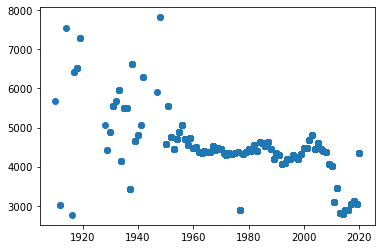

In [121]:
plt.scatter(df_train['HouseYear'], df_train['PricePerSquareByHouseYear']);

### Анализ корреляционных зависимостей в данных

In [122]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14038 to 6306
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   DistrictId                  10000 non-null  object 
 1   Rooms                       10000 non-null  float64
 2   Square                      10000 non-null  float64
 3   LifeSquare                  10000 non-null  float64
 4   KitchenSquare               10000 non-null  float64
 5   Floor                       10000 non-null  int64  
 6   HouseFloor                  10000 non-null  float64
 7   HouseYear                   10000 non-null  int64  
 8   Ecology_1                   10000 non-null  float64
 9   Ecology_2                   10000 non-null  int64  
 10  Ecology_3                   10000 non-null  int64  
 11  Social_1                    10000 non-null  int64  
 12  Social_2                    10000 non-null  int64  
 13  Social_3                    

In [123]:
df_train.corr()

Rooms    Square  LifeSquare  KitchenSquare  \
Rooms                       1.000000  0.731398    0.511879       0.005123   
Square                      0.731398  1.000000    0.767980       0.008493   
LifeSquare                  0.511879  0.767980    1.000000      -0.038964   
KitchenSquare               0.005123  0.008493   -0.038964       1.000000   
Floor                      -0.000665  0.118084    0.124433      -0.011397   
HouseFloor                 -0.036342  0.113114    0.100024      -0.010155   
HouseYear                  -0.038606  0.191306    0.089974       0.038525   
Ecology_1                  -0.032347 -0.071320   -0.085730      -0.005622   
Ecology_2                  -0.001971  0.032585    0.038422       0.000268   
Ecology_3                  -0.005909  0.024325    0.061800      -0.007919   
Social_1                    0.075980 -0.079494   -0.278024       0.043379   
Social_2                    0.071335 -0.049462   -0.232444       0.037805   
Social_3                    0.012811  0.021886    0.049632      -0.015140   
Healthcare_1                0.047007 -0.016141   -0.104178       0.030635   
Helthcare_2                 0.063557 -0.033117   -0.157980       0.043170   
Shops_1                     0.053618  0.010296   -0.056813       0.010216   
Shops_2                    -0.000146 -0.055983   -0.085320      -0.017315   
Price                       0.550291  0.582257    0.299046       0.028864   
PricePerSquare             -0.032784 -0.196839   -0.322949       0.025844   
PricePerSquareByDistrictId  0.115383 -0.056623   -0.256391       0.046437   
PricePerSquareByHouseYear   0.098067 -0.179366   -0.436150       0.050980   

                               Floor  HouseFloor  HouseYear  Ecology_1  \
Rooms                      -0.000665   -0.036342  -0.038606  -0.032347   
Square                      0.118084    0.113114   0.191306  -0.071320   
LifeSquare                  0.124433    0.100024   0.089974  -0.085730   
KitchenSquare              -0.011397   -0.010155   0.038525  -0.005622   
Floor                       1.000000    0.461975   0.284459  -0.016133   
HouseFloor                  0.461975    1.000000   0.411734  -0.018792   
HouseYear                   0.284459    0.411734   1.000000  -0.066438   
Ecology_1                  -0.016133   -0.018792  -0.066438   1.000000   
Ecology_2                   0.049661    0.069539   0.076806  -0.110725   
Ecology_3                   0.025767    0.018730   0.047153  -0.223197   
Social_1                   -0.044914   -0.068519  -0.047962   0.026464   
Social_2                   -0.016560   -0.033584   0.013622   0.009264   
Social_3                   -0.002237   -0.026501  -0.049389  -0.124068   
Healthcare_1               -0.088716   -0.140105  -0.140895   0.015173   
Helthcare_2                -0.065537   -0.106748  -0.116430   0.030873   
Shops_1                     0.024264   -0.005133  -0.002162  -0.076749   
Shops_2                    -0.013626    0.000436  -0.058865   0.079809   
Price                       0.128715    0.088439   0.036574  -0.058381   
PricePerSquare              0.017157   -0.037233  -0.165249  -0.005355   
PricePerSquareByDistrictId -0.079066   -0.131715  -0.232442   0.014034   
PricePerSquareByHouseYear  -0.216358   -0.226125  -0.340409   0.095766   

                            Ecology_2  Ecology_3  ...  Social_2  Social_3  \
Rooms                       -0.001971  -0.005909  ...  0.071335  0.012811   
Square                       0.032585   0.024325  ... -0.049462  0.021886   
LifeSquare                   0.038422   0.061800  ... -0.232444  0.049632   
KitchenSquare                0.000268  -0.007919  ...  0.037805 -0.015140   
Floor                        0.049661   0.025767  ... -0.016560 -0.002237   
HouseFloor                   0.069539   0.018730  ... -0.033584 -0.026501   
HouseYear                    0.076806   0.047153  ...  0.013622 -0.049389   
Ecology_1                   -0.110725  -0.223197  ...  0.009264 -0.124068   
Ecology_2     

In [124]:
df_train.corr().style.background_gradient(cmap='coolwarm').set_precision(2)

По результатам анализа не создано новых гипотез.

### Отбор признаков

In [125]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14038 to 6306
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   DistrictId                  10000 non-null  object 
 1   Rooms                       10000 non-null  float64
 2   Square                      10000 non-null  float64
 3   LifeSquare                  10000 non-null  float64
 4   KitchenSquare               10000 non-null  float64
 5   Floor                       10000 non-null  int64  
 6   HouseFloor                  10000 non-null  float64
 7   HouseYear                   10000 non-null  int64  
 8   Ecology_1                   10000 non-null  float64
 9   Ecology_2                   10000 non-null  int64  
 10  Ecology_3                   10000 non-null  int64  
 11  Social_1                    10000 non-null  int64  
 12  Social_2                    10000 non-null  int64  
 13  Social_3                    

In [126]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 725 to 12504
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   DistrictId                  5000 non-null   object 
 1   Rooms                       5000 non-null   float64
 2   Square                      5000 non-null   float64
 3   LifeSquare                  5000 non-null   float64
 4   KitchenSquare               5000 non-null   float64
 5   Floor                       5000 non-null   int64  
 6   HouseFloor                  5000 non-null   float64
 7   HouseYear                   5000 non-null   int64  
 8   Ecology_1                   5000 non-null   float64
 9   Ecology_2                   5000 non-null   int64  
 10  Ecology_3                   5000 non-null   int64  
 11  Social_1                    5000 non-null   int64  
 12  Social_2                    5000 non-null   int64  
 13  Social_3                    50

In [127]:
df_train.to_csv('train_prepared.csv')
df_test.to_csv('test_prepared.csv')

In [128]:
feature_names = df_train.columns
feature_names.tolist()

['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'PricePerSquare',
 'PricePerSquareByDistrictId',
 'PricePerSquareByHouseYear']

In [129]:
feature_names_full = [feature for feature in feature_names if feature not in ['Price', 'PricePerSquare']]
len(feature_names_full)

20

In [130]:
target_name = ['Price']
feature_names = [
    #'DistrictId',
     'Rooms',
     'Square',
    #'LifeSquare',
     'KitchenSquare',
     'Floor',
     'HouseFloor',
     'HouseYear',
     'Ecology_1',
     'Ecology_2',
     'Ecology_3',
     'Social_1',
     'Social_2',
     'Social_3',
    #'Healthcare_1',
     'Helthcare_2',
    #'Shops_1',
     'Shops_2',
     'PricePerSquareByDistrictId',
     'PricePerSquareByHouseYear'
]

In [131]:
X = df_train[feature_names]
y = df_train[target_name]

In [132]:
len(feature_names)

16

### Прогноз на модели Random Forest

In [133]:
forest = RandomForestRegressor(random_state=42, max_depth=16, max_features=5)
kf = KFold(n_splits=5, random_state=42, shuffle=True)

cv_score = cross_val_score(forest, X, y, scoring='r2', cv=kf)
print('R2: {:.5f}'.format(cv_score.mean()))

/Users/alexander/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/Users/alexander/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/Users/alexander/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/Users/alexander/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n

R2: 0.76703


In [134]:
# Поочерёдный перебор вариантов

# R2: 0.73416 - 16 признаков
# - кодирование категориальных признаков методом Label Encoding;
# - удаление признака 'LifeSquare;
# - удаление признака 'Healthcare_1’.

# R2: 0.73310 - 17 признаков
# - кодирование категориальных признаков методом Label Encoding;
# - замена пропущенных значений признака 'LifeSquare' медианой (-);
# - удаление признака 'Healthcare_1’.

# R2: 0.73422 - 17 признаков
# - кодирование категориальных признаков методом Label Encoding;
# - замена пропущенных значений признака 'LifeSquare' разницей между значениями признака 'Square' и 'KitchenSquare’ (+);
# - удаление признака 'Healthcare_1’.

# R2: 0.73328 - 18 признаков
# - кодирование категориальных признаков методом Label Encoding;
# - замена пропущенных значений признака 'LifeSquare' разницей между значениями признака 'Square' и 'KitchenSquare’ (+);
# - замена пропущенных значений признака 'Healthcare_1' медианой (-).

# R2: 0.73473 - 18 признаков
# - кодирование категориальных признаков методом Label Encoding;
# - замена пропущенных значений признака 'LifeSquare' разницей между значениями признака 'Square' и 'KitchenSquare’ (+);
# - замена пропущенных значений признака 'Healthcare_1' медианой значений, сгруппированных по признаку 'DistrictId'
# с дозаполнением оставшихся значений медианой сгруппированных значений (+).

# R2: 0.73418 - 18 признаков
# - кодирование категориальных признаков методом Label Encoding;
# - замена пропущенных значений признака 'LifeSquare' разницей между значениями признака 'Square' и 'KitchenSquare’ (+);
# - замена пропущенных значений признака 'Healthcare_1' медианой значений, сгруппированных по признаку 'DistrictId'
# с дозаполнением оставшихся значений медианой сгруппированных значений;
# - замена аномальных значений признака 'Rooms' модой исходя из критерия адекватности признака (-).

# R2: 0.73421- 18 признаков
# - кодирование категориальных признаков методом Label Encoding;
# - замена пропущенных значений признака 'LifeSquare' разницей между значениями признака 'Square' и 'KitchenSquare’ (+);
# - замена пропущенных значений признака 'Healthcare_1' медианой значений, сгруппированных по признаку 'DistrictId'
# с дозаполнением оставшихся значений медианой сгруппированных значений (+);
# - замена аномальных значений признака 'KitchenSquare' медианой исходя из предположения о критерии выброса (-).

# R2: 0.73504 - 18 признаков
# - кодирование категориальных признаков методом Label Encoding;
# - замена пропущенных значений признака 'LifeSquare' разницей между значениями признака 'Square' и 'KitchenSquare’ (+);
# - замена пропущенных значений признака 'Healthcare_1' медианой значений, сгруппированных по признаку 'DistrictId'
# с дозаполнением оставшихся значений медианой сгруппированных значений (+);
# - замена аномальных значений признака 'LifeSquare' медианой исходя из предположения о критерии выброса (+).

# R2: 0.73458 - 18 признаков
# - кодирование категориальных признаков методом Label Encoding;
# - замена пропущенных значений признака 'LifeSquare' разницей между значениями признака 'Square' и 'KitchenSquare’ (+);
# - замена пропущенных значений признака 'Healthcare_1' медианой значений, сгруппированных по признаку 'DistrictId'
# с дозаполнением оставшихся значений медианой сгруппированных значений (+);
# - замена аномальных значений признака 'LifeSquare' медианой исходя из предположения о критерии выброса (+);
# - замена аномальных значений признака 'Square' медианой исходя из предположения о критерии выброса (-).

# R2: 0.72222 - 18 признаков
# - кодирование категориальных признаков методом Label Encoding;
# - замена пропущенных значений признака 'LifeSquare' разницей между значениями признака 'Square' и 'KitchenSquare’ (+);
# - замена пропущенных значений признака 'Healthcare_1' медианой значений, сгруппированных по признаку 'DistrictId'
# с дозаполнением оставшихся значений медианой сгруппированных значений (+);
# - замена аномальных значений признака 'LifeSquare' медианой исходя из предположения о критерии выброса (+);
# - замена аномальных значений признаков 'Square', 'LifeSquare' и 'KitchenSquare' их медианами исходя из критерия
# адекватности данных признаков (-).

# R2: 0.73544 - 18 признаков
# - кодирование категориальных признаков методом Label Encoding;
# - замена пропущенных значений признака 'LifeSquare' разницей между значениями признака 'Square' и 'KitchenSquare’ (+);
# - замена пропущенных значений признака 'Healthcare_1' медианой значений, сгруппированных по признаку 'DistrictId'
# с дозаполнением оставшихся значений медианой сгруппированных значений (+);
# - замена аномальных значений признака 'LifeSquare' медианой исходя из предположения о критерии выброса (+);
# - замена аномальных значений признака 'HouseFloor' медианой исходя из предположения о критерии выброса (+).

# R2: 0.73158 - 18 признаков
# - кодирование категориальных признаков методом Label Encoding;
# - замена пропущенных значений признака 'LifeSquare' разницей между значениями признака 'Square' и 'KitchenSquare’ (+);
# - замена пропущенных значений признака 'Healthcare_1' медианой значений, сгруппированных по признаку 'DistrictId'
# с дозаполнением оставшихся значений медианой сгруппированных значений (+);
# - замена аномальных значений признака 'LifeSquare' медианой исходя из предположения о критерии выброса (+);
# - замена аномальных значений признака 'HouseFloor' медианой исходя из предположения о критерии выброса (+);
# - замена аномальных значений признаков 'Floor' и 'HouseFloor' их медианами исходя из критерия адекватности данных признаков (-).

# R2: 0.73529 - 18 признаков
# - кодирование категориальных признаков методом Label Encoding;
# - замена пропущенных значений признака 'LifeSquare' разницей между значениями признака 'Square' и 'KitchenSquare’ (+);
# - замена пропущенных значений признака 'Healthcare_1' медианой значений, сгруппированных по признаку 'DistrictId'
# с дозаполнением оставшихся значений медианой сгруппированных значений (+);
# - замена аномальных значений признака 'LifeSquare' медианой исходя из предположения о критерии выброса (+);
# - замена аномальных значений признака 'HouseFloor' медианой исходя из предположения о критерии выброса (+);
# - замена аномальных значений признака 'HouseYear' медианой исходя из критерия адекватности признака (-).

# R2: 0.74723 - 19 признаков
# - кодирование категориальных признаков методом Label Encoding;
# - замена пропущенных значений признака 'LifeSquare' разницей между значениями признака 'Square' и 'KitchenSquare’ (+);
# - замена пропущенных значений признака 'Healthcare_1' медианой значений, сгруппированных по признаку 'DistrictId'
# с дозаполнением оставшихся значений медианой сгруппированных значений (+);
# - замена аномальных значений признака 'LifeSquare' медианой исходя из предположения о критерии выброса (+);
# - замена аномальных значений признака 'HouseFloor' медианой исходя из предположения о критерии выброса (+);
# - добавление нового временного признака «стоимость квадратного метра» (+);
# - добавление нового признака «сгруппированная по районам медианная стоимость квадратного метра» с дозаполнением пропущенных значений медианой (+).

# R2: 0.75463 - 20 признаков
# - кодирование категориальных признаков методом Label Encoding;
# - замена пропущенных значений признака 'LifeSquare' разницей между значениями признака 'Square' и 'KitchenSquare’ (+);
# - замена пропущенных значений признака 'Healthcare_1' медианой значений, сгруппированных по признаку 'DistrictId'
# с дозаполнением оставшихся значений медианой сгруппированных значений (+);
# - замена аномальных значений признака 'LifeSquare' медианой исходя из предположения о критерии выброса (+);
# - замена аномальных значений признака 'HouseFloor' медианой исходя из предположения о критерии выброса (+);
# - добавление нового временного признака «стоимость квадратного метра» (+);
# - добавление нового признака «сгруппированная по районам медианная стоимость квадратного метра» с дозаполнением пропущенных значений медианой (+);
# - добавление нового признака «сгруппировання по годам медианная стоимость квадратного метра» с дозаполнением пропущенных значений медианой (+).

# R2: 0.75491 - 20 признаков
# - кодирование категориальных признаков методом Label Encoding;
# - замена пропущенных значений признака 'LifeSquare' разницей между значениями признака 'Square' и 'KitchenSquare’ (+);
# - замена пропущенных значений признака 'Healthcare_1' медианой значений, сгруппированных по признаку 'DistrictId'
# с дозаполнением оставшихся значений медианой сгруппированных значений (+);
# - замена аномальных значений признака 'LifeSquare' медианой исходя из предположения о критерии выброса (+);
# - замена аномальных значений признака 'HouseFloor' медианой исходя из предположения о критерии выброса (+);
# - добавление нового временного признака «стоимость квадратного метра» (+);
# - добавление нового признака «сгруппированная по районам медианная стоимость квадратного метра» с дозаполнением пропущенных значений медианой (+);
# - добавление нового признака «сгруппировання по годам медианная стоимость квадратного метра» с дозаполнением пропущенных значений медианой (+);
# - замена аномальных значений признака 'HouseYear' медианой исходя из критерия адекватности признака (+).

# R2: 0.75516 - 20 признаков
# - кодирование категориальных признаков методом Label Encoding;
# - замена пропущенных значений признака 'LifeSquare' разницей между значениями признака 'Square' и 'KitchenSquare’ (+);
# - замена пропущенных значений признака 'Healthcare_1' медианой значений, сгруппированных по признаку 'DistrictId'
# с дозаполнением оставшихся значений медианой сгруппированных значений (+);
# - замена аномальных значений признака 'LifeSquare' медианой исходя из предположения о критерии выброса (+);
# - замена аномальных значений признака 'HouseFloor' медианой исходя из предположения о критерии выброса (+);
# - добавление нового временного признака «стоимость квадратного метра» (+);
# - добавление нового признака «сгруппированная по районам медианная стоимость квадратного метра» с дозаполнением пропущенных значений медианой (+);
# - добавление нового признака «сгруппировання по годам медианная стоимость квадратного метра» с дозаполнением пропущенных значений медианой (+);
# - замена аномальных значений признака 'HouseYear' медианой исходя из критерия адекватности признака (+);
# - замена аномальных значений признака 'Square' медианой исходя из предположения о критерии выброса (+).

In [135]:
#### Чек-лист перебора вариантов

# Вариант 1*. Кодирование категориальных признаков методом Label Encoding.
# Вариант 2a. Удаление признака 'LifeSquare.
# Вариант 2b. Замена пропущенных значений признака 'LifeSquare' медианой.
# Вариант 2с*. Замена пропущенных значений признака 'LifeSquare' разницей между значениями признака 'Square' и 'KitchenSquare’.
# Вариант 2d (исключён). Замена пропущенных значений признака 'LifeSquare' значениями, вычисляемыми с помощью линейной модели.

# Вариант 3a. Удаление признака 'Healthcare_1’.
# Вариант 3b. Замена пропущенных значений признака 'Healthcare_1' медианой.
# Вариант 3с*. Замена пропущенных значений признака 'Healthcare_1' медианой значений, сгруппированных по признаку 'DistrictId' с дозаполнением оставшихся значений по варианту 3b.
# Вариант 3d (исключён). Замена пропущенных значений признака 'Healthcare_1' значениями, вычисляемыми с помощью линейной модели.

# Вариант 4 (—). Замена аномальных значений признака 'Rooms' модой исходя из критерия адекватности признака.

# Вариант 5a (—). Замена аномальных значений признака 'KitchenSquare' медианой исходя из предположения о критерии выброса.
# Вариант 5b*. Замена аномальных значений признака 'LifeSquare' медианой исходя из предположения о критерии выброса.
# Вариант 5c**. Замена аномальных значений признака 'Square' медианой исходя из предположения о критерии выброса.
# Вариант 5d (—). Замена аномальных значений признаков 'Square', 'LifeSquare' и 'KitchenSquare' их медианами исходя из критерия адекватности данных признаков.

# Вариант 6a*. Замена аномальных значений признака 'HouseFloor' медианой исходя из предположения о критерии выброса.
# Вариант 6b (—). Замена аномальных значений признаков 'Floor' и 'HouseFloor' их медианами исходя из критерия адекватности данных признаков.

# Вариант 7. Замена аномальных значений признака 'HouseYear' медианой исходя из критерия адекватности признака**.

# Вариант 8a*. Добавление нового временного признака «стоимость квадратного метра».
# Вариант 8b*. Добавление нового признака «сгруппированная по районам медианная стоимость квадратного метра» с дозаполнением пропущенных значений медианой.
# Вариант 8с*. Добавление нового признака «сгруппировання по годам медианная стоимость квадратного метра» с дозаполнением пропущенных значений медианой.

# Легенда:

# *   принятый к использованию вариант;
# **  принятый к использованию вариант после второго перебора; 
# (—) подтверждено исключение варианта после второго перебора.

In [136]:
# Поочерёдный перебор признаков от менее значимого к более значимому (представлено для случаев с улучшением метрики)

# R2: 0.75539 - 19 признаков, исключён 'Shops_1'
# R2: 0.75615 - 18 признаков, исключён 'Healthcare_1'
# R2: 0.75583 - 17 признаков, исключён 'DistrictId'
# R2: 0.75697 - 16 признаков, исключён 'LifeSquare'
# R2: 0.76703 - - 16 признаков, подбор параметров с помощью GridSearchCV

Анализ важности признаков:

<ipython-input-137-236973a4a59a>:1: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



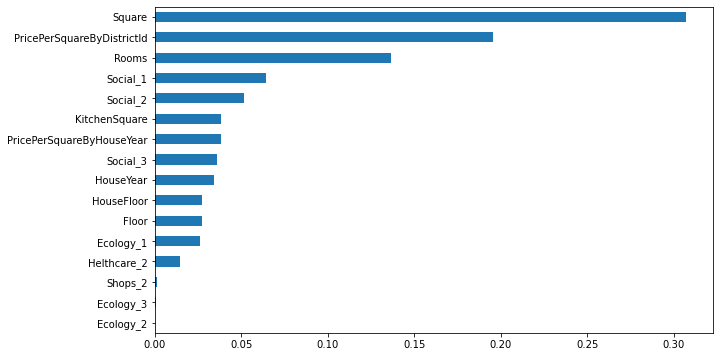

In [137]:
forest.fit(X, y)
importances = forest.feature_importances_
feat_importances = pd.Series(importances, index=feature_names)
feat_importances.sort_values(ascending=True, inplace=True)
feat_importances.plot(kind='barh', figsize=(10, 6));

Настройка гиперпараметров модели:

In [138]:
params = {
#    'n_estimators': [100],
    'max_depth': [15, 16, 17],
    'max_features': [4, 5, 6]
}

In [139]:
forest_grid = GridSearchCV(forest, params, scoring='r2', 
                  cv=KFold(n_splits=5, random_state=42, shuffle=True), 
                  n_jobs=-1)
forest_grid.fit(X, y)
print(forest_grid.best_params_)
print('R2 на train: {:.5f}'.format(forest_grid.best_score_)) 

/Users/alexander/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:880: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



{'max_depth': 16, 'max_features': 5}
R2 на train: 0.76703


### Прогноз на модели Gradient Boosting

In [140]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=7,
                                     min_samples_leaf=10,
                                     random_state=42,  
                                     n_estimators=100)
kf = KFold(n_splits=5, random_state=42, shuffle=True)

cv_score = cross_val_score(gb_model, X, y, scoring='r2', cv=kf)
print('R2: {:.5f}'.format(cv_score.mean()))

/Users/alexander/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/alexander/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/alexander/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/alexander/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Use

R2: 0.76236


In [141]:
params = {
    'n_estimators': [25, 50, 100],
    'max_depth': [14, 15, 16],
    'max_features': [4, 5, 6]
}

In [142]:
gb_model_grid = GridSearchCV(gb_model, params, scoring='r2', 
                  cv=KFold(n_splits=5, random_state=42, shuffle=True), 
                  n_jobs=-1)
gb_model_grid.fit(X, y)
print(gb_model_grid.best_params_)
print('R2 на train: {:.5f}'.format(gb_model_grid.best_score_))

/Users/alexander/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



{'max_depth': 15, 'max_features': 5, 'n_estimators': 50}
R2 на train: 0.76361


### Прогноз лучшей модели на тестовом датасете

In [143]:
model_best = RandomForestRegressor(random_state=42, 
                                   max_depth=16, 
                                   max_features=5)
model_best.fit(X, y)
y_pred = model_best.predict(df_test[feature_names])
y_pred

<ipython-input-143-8b9ca6c99b1e>:4: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



array([155172.64404829, 226233.86249888, 255328.8328318 , ...,
       313233.5733986 , 191300.49651488, 180253.4106288 ])

In [144]:
preds = pd.DataFrame()
preds['Id'] = df_test.index
preds['Price'] = y_pred
preds.head()

Id          Price
0    725  155172.644048
1  15856  226233.862499
2   5480  255328.832832
3  15664  324266.930675
4  14275  145625.018719

In [145]:
preds.to_csv('AVDunaev_predictions.csv', index=False)